# Correlation Analysis

Using PCA and PLS the goal of this notebook is to assess the strengh of relationships between potential input features to the ANN and marginal emissions.

All the input data features available are:
* Demand
* Generation
* Carbon Emissions
* Carbon Intensity
* Wind Generation
* Net Interconnection
* System Frequency
* Fuel mix
* Net inmbalance volume
* Imbalance settlement price

The goal is to determine which features contribute most to the MEF based on PCA/PLS.

## Data Pre-Processing

The data sets have been cleaned/processed using the `semo_data_processing.py` and `eirgrid_data_cleaning.py` script. What needs to be done is create a data frame that combines all of these input features alonside the target value - MEF into one. 

This then will be normalised using a Standard scaler and fed into the PCA algorithim

In [90]:
import pandas as pd
import sys
import os
import datetime
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import numpy as np
sys.path.insert(0, os.path.abspath('../')) 

from lib.common import constants as k
from lib.eirgrid import data as eirgrid_data
from lib.common.marginal_emissions import compute_mef

# Eirgrid system
eirgrid = eirgrid_data.system()

# Fuel mix
fuel_mix = pd.read_csv(k.PROCESSED_DATA_DIR / 'fuel_mix.csv', index_col=0)
fuel_mix.rename(columns={'StartTime': 'EffectiveTime'}, inplace=True)
fuel_mix['EffectiveTime'] = pd.to_datetime(fuel_mix['EffectiveTime'])

# Pricing data
pricing = pd.read_csv(k.RAW_DATA_DIR / 'semo' / 'price_all.csv', index_col=0)
pricing = pricing[['StartTime', 'NetImbalanceVolume', 'ImbalanceSettlementPrice']]
pricing.rename(columns={'StartTime': 'EffectiveTime'}, inplace=True)
pricing['EffectiveTime'] = pd.to_datetime(pricing['EffectiveTime'])

display(eirgrid) 
display(fuel_mix)
display(pricing)

,EffectiveTime,SysFrequency,Co2Emissions,Co2Intensity,SystemDemand,GenExp,InterNet,WindActual
0,2023-12-28 23:30:00,50.02,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-12-28 23:15:00,49.99,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-12-28 23:00:00,50.09,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-12-28 22:45:00,50.01,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-12-28 22:30:00,50.04,NaN,NaN,NaN,NaN,NaN,3459.0
...,...,...,...,...,...,...,...,...
356110,2013-11-01 01:00:00,NaN,NaN,NaN,3205.0,2972.0,457.0,892.0
356111,2013-11-01 00:45:00,NaN,NaN,NaN,3260.0,3028.0,282.0,886.0
356112,2013-11-01 00:30:00,NaN,NaN,NaN,3336.0,3050.0,-175.0,891.0
356113,2013-11-01 00:15:00,NaN,NaN,NaN,3421.0,3059.0,336.0,892.0


,EffectiveTime,COAL_GAS,OTHER,RENEWABLES
0,2023-12-27 23:30:00,165.056,456.582,1116.799
1,2023-12-27 23:00:00,165.126,458.484,1202.035
2,2023-12-27 22:30:00,164.268,452.172,1254.472
3,2023-12-27 22:00:00,167.159,472.501,1283.267
4,2023-12-27 21:30:00,166.880,460.263,1244.638
...,...,...,...,...
4322,2023-09-29 01:00:00,331.294,901.812,1610.381
4323,2023-09-29 00:30:00,332.214,892.146,1711.846
4324,2023-09-29 00:00:00,332.412,901.898,1729.742
4325,2023-09-28 23:30:00,335.524,921.120,1750.178


,EffectiveTime,NetImbalanceVolume,ImbalanceSettlementPrice
0,2023-09-28 23:00:00,-16.843,-5.36
1,2023-09-28 23:30:00,-22.500,-26.01
2,2023-09-29 00:00:00,-18.588,-20.92
3,2023-09-29 00:30:00,-18.884,-26.04
4,2023-09-29 01:00:00,-26.958,-25.03
...,...,...,...
4352,2023-12-28 19:30:00,14.578,119.37
4353,2023-12-28 20:00:00,11.835,118.38
4354,2023-12-28 20:30:00,-0.665,58.20
4355,2023-12-28 21:00:00,-10.572,0.00


* There are empty values in the eirgrid system
* The data must be resampled to half-hourly intervals

In [27]:
eirgrid_df = eirgrid.set_index('EffectiveTime')
eirgrid_df = eirgrid_df.resample('30T').asfreq()
eirgrid_df = eirgrid_df.reset_index()
eirgrid_df = eirgrid_df.dropna()
eirgrid_df

,EffectiveTime,SysFrequency,Co2Emissions,Co2Intensity,SystemDemand,GenExp,InterNet,WindActual
116832,2020-07-01 00:00:00,50.04,1746.0,442.0,3509.0,3849.0,162.0,250.0
116833,2020-07-01 00:30:00,50.07,1698.0,443.0,3376.0,3730.0,0.0,239.0
116834,2020-07-01 01:00:00,50.06,1506.0,414.0,3249.0,3542.0,-120.0,246.0
116835,2020-07-01 01:30:00,49.94,1425.0,398.0,3158.0,3484.0,159.0,252.0
116836,2020-07-01 02:00:00,49.96,1431.0,399.0,3094.0,3487.0,-223.0,252.0
...,...,...,...,...,...,...,...,...
178047,2023-12-28 07:30:00,50.01,672.0,168.0,4002.0,4742.0,-306.0,3283.0
178048,2023-12-28 08:00:00,49.99,666.0,160.0,4150.0,4868.0,407.0,3405.0
178049,2023-12-28 08:30:00,49.95,682.0,159.0,4295.0,5023.0,-290.0,3511.0
178050,2023-12-28 09:00:00,50.02,687.0,154.0,4473.0,5201.0,-288.0,3719.0


Join this with the fuel mix and pricing data

In [73]:
# Join with fuel mix data
df = eirgrid_df.merge(fuel_mix, on='EffectiveTime', how='left')
df = df.dropna()

# Join with pricing data
df = df.merge(pricing, on='EffectiveTime', how='left')
df = df.dropna()

# Calculate MEF
df = compute_mef(df).dropna()
df

,EffectiveTime,SysFrequency,Co2Emissions,Co2Intensity,SystemDemand,GenExp,InterNet,WindActual,COAL_GAS,OTHER,RENEWABLES,NetImbalanceVolume,ImbalanceSettlementPrice,MarginalEmissions
0,2023-09-28 23:00:00,50.00,812.0,199.0,4080.0,4016.0,273.0,2421.0,332.864,948.134,1890.593,-16.843,-5.36,-60.344262
1,2023-09-28 23:30:00,49.96,792.0,203.0,3909.0,3955.0,0.0,2385.0,335.524,921.120,1750.178,-22.500,-26.01,203.000000
2,2023-09-29 00:00:00,49.98,763.0,203.0,3751.0,3802.0,177.0,2324.0,332.412,901.898,1729.742,-18.588,-20.92,125.347826
3,2023-09-29 00:30:00,50.01,761.0,208.0,3659.0,3572.0,0.0,2125.0,332.214,892.146,1711.846,-18.884,-26.04,66.189189
4,2023-09-29 01:00:00,50.02,753.0,211.0,3573.0,3498.0,0.0,2076.0,331.294,901.812,1610.381,-26.958,-25.03,-160.785714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3733,2023-12-27 21:00:00,49.98,702.0,147.0,4765.0,4476.0,77.0,2885.0,173.331,470.241,1303.889,32.714,114.22,488.307692
3734,2023-12-27 21:30:00,50.01,671.0,144.0,4663.0,4437.0,0.0,2965.0,166.880,460.263,1244.638,36.977,126.25,-403.625000
3735,2023-12-27 22:00:00,49.95,682.0,151.0,4512.0,4381.0,150.0,2855.0,167.159,472.501,1283.267,43.218,120.00,329.240000
3736,2023-12-27 22:30:00,50.00,674.0,154.0,4381.0,4456.0,3.0,2979.0,164.268,452.172,1254.472,31.130,125.04,49.317073


<Axes: >

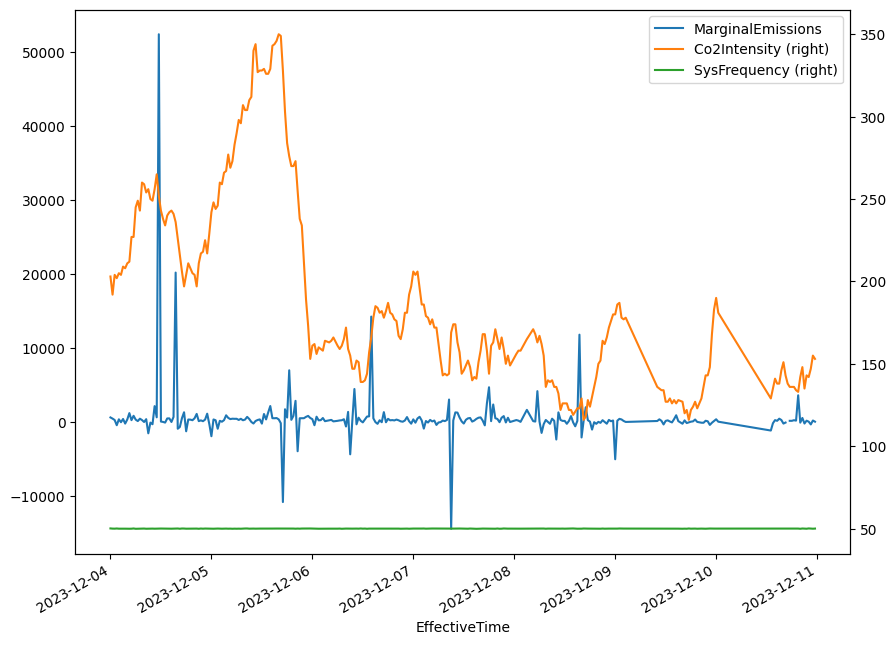

In [183]:
fig, ax = plt.subplots(figsize=(10,8)) 
week = df[df['EffectiveTime'].dt.isocalendar().week == 49]
week.plot(x='EffectiveTime', y='MarginalEmissions', ax=ax)
week.plot(x='EffectiveTime', y=['Co2Intensity', 'SysFrequency'], ax=ax, secondary_y=True)

Deal with datetime values 

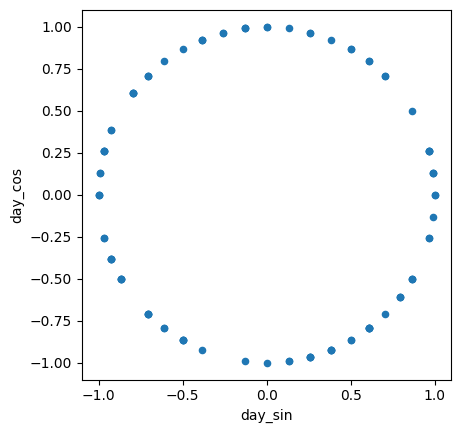

In [208]:
features = df.copy()
timestamp_s = df['EffectiveTime'].map(datetime.datetime.timestamp)
day = 24 * 60 * 60
features['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
features['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values
target = features['MarginalEmissions']
features = features.drop(columns=['EffectiveTime', 'MarginalEmissions'])
features.sample(100).plot.scatter('day_sin','day_cos').set_aspect('equal')

Scale the data

In [207]:
# scaler = StandardScaler()
# scaler.fit(features)
# features[features.columns] = scaler.transform(features[features.columns])
# features

/Users/jesseonolememen/Documents/University/Final Year Project/projection/venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jesseonolememen/Documents/University/Final Year Project/projection/venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jesseonolememen/Documents/University/Final Year Project/projection/venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


,SysFrequency,Co2Emissions,Co2Intensity,SystemDemand,GenExp,InterNet,WindActual,COAL_GAS,OTHER,RENEWABLES,NetImbalanceVolume,ImbalanceSettlementPrice,day_sin,day_cos,MarginalEmissions
0,-0.085981,-0.789451,-0.493495,-0.873614,-0.304251,0.195248,0.726149,-1.197789,-1.232247,-0.265099,-0.728875,-1.913612,-0.688838,1.253207,NaN
1,-1.017267,-0.844156,-0.429042,-1.079942,-0.372739,-0.368019,0.692605,-1.193765,-1.256797,-0.353020,-0.951929,-2.234622,-0.523349,1.335272,NaN
2,-0.551624,-0.923479,-0.429042,-1.270584,-0.544519,-0.002824,0.635766,-1.198472,-1.274266,-0.365816,-0.797680,-2.155496,-0.348624,1.394913,NaN
3,0.146840,-0.928950,-0.348477,-1.381591,-0.802752,-0.368019,0.450341,-1.198772,-1.283128,-0.377021,-0.809351,-2.235088,-0.167652,1.431111,NaN
4,0.379662,-0.950832,-0.300138,-1.485358,-0.885835,-0.368019,0.404684,-1.200163,-1.274344,-0.440554,-1.127707,-2.219388,0.016470,1.443246,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3733,-0.551624,-1.090330,-1.331376,-0.047097,0.212214,-0.209148,1.158496,-1.439096,-1.666549,-0.632463,1.225147,-0.054707,-0.980986,1.027786,NaN
3734,0.146840,-1.175124,-1.379716,-0.170169,0.168427,-0.368019,1.233039,-1.448854,-1.675617,-0.669563,1.393236,0.132302,-0.842258,1.150124,NaN
3735,-1.250089,-1.145036,-1.266924,-0.352365,0.105553,-0.058531,1.130543,-1.448432,-1.664495,-0.645376,1.639318,0.035144,-0.688838,1.253207,NaN
3736,-0.085981,-1.166918,-1.218585,-0.510429,0.189759,-0.361829,1.246084,-1.452805,-1.682970,-0.663406,1.162690,0.113492,-0.523349,1.335272,NaN


In [211]:
from greytheory import GreyTheory
grey = GreyTheory()
gm0n = grey.gm0n

display(features)
gm0n.add_outputs(target.values.tolist(), "x1")
for column in features.columns:
    gm0n.add_patterns(features[column].values.tolist(), column)
# gm0n.add_patterns(features[''], "x2")
# gm0n.add_patterns([.5, 1., .7, .66, 1., .5], "x3")
# gm0n.add_patterns([1., 1.09, .4, .33, .66, .25], "x4")
# gm0n.add_patterns([.25, .99, 1., .66, .33, .25], "x5")

gm0n.analyze()

# Looks GM0N the results as below:
gm0n.print_analyzed_results()
gm0n.print_influence_degrees()

,SysFrequency,Co2Emissions,Co2Intensity,SystemDemand,GenExp,InterNet,WindActual,COAL_GAS,OTHER,RENEWABLES,NetImbalanceVolume,ImbalanceSettlementPrice,day_sin,day_cos
0,50.00,812.0,199.0,4080.0,4016.0,273.0,2421.0,332.864,948.134,1890.593,-16.843,-5.36,-5.000000e-01,0.866025
1,49.96,792.0,203.0,3909.0,3955.0,0.0,2385.0,335.524,921.120,1750.178,-22.500,-26.01,-3.826834e-01,0.923880
2,49.98,763.0,203.0,3751.0,3802.0,177.0,2324.0,332.412,901.898,1729.742,-18.588,-20.92,-2.588190e-01,0.965926
3,50.01,761.0,208.0,3659.0,3572.0,0.0,2125.0,332.214,892.146,1711.846,-18.884,-26.04,-1.305262e-01,0.991445
4,50.02,753.0,211.0,3573.0,3498.0,0.0,2076.0,331.294,901.812,1610.381,-26.958,-25.03,-1.054180e-11,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3733,49.98,702.0,147.0,4765.0,4476.0,77.0,2885.0,173.331,470.241,1303.889,32.714,114.22,-7.071068e-01,0.707107
3734,50.01,671.0,144.0,4663.0,4437.0,0.0,2965.0,166.880,460.263,1244.638,36.977,126.25,-6.087614e-01,0.793353
3735,49.95,682.0,151.0,4512.0,4381.0,150.0,2855.0,167.159,472.501,1283.267,43.218,120.00,-5.000000e-01,0.866025
3736,50.00,674.0,154.0,4381.0,4456.0,3.0,2979.0,164.268,452.172,1254.472,31.130,125.04,-3.826834e-01,0.923880


'GreyGM0N'
Pattern key: 'SysFrequency', grey value: nan, ranking: 1
Pattern key: 'Co2Emissions', grey value: nan, ranking: 2
Pattern key: 'Co2Intensity', grey value: nan, ranking: 3
Pattern key: 'SystemDemand', grey value: nan, ranking: 4
Pattern key: 'GenExp', grey value: nan, ranking: 5
Pattern key: 'InterNet', grey value: nan, ranking: 6
Pattern key: 'WindActual', grey value: nan, ranking: 7
Pattern key: 'COAL_GAS', grey value: nan, ranking: 8
Pattern key: 'OTHER', grey value: nan, ranking: 9
Pattern key: 'RENEWABLES', grey value: nan, ranking: 10
Pattern key: 'NetImbalanceVolume', grey value: nan, ranking: 11
Pattern key: 'ImbalanceSettlementPrice', grey value: nan, ranking: 12
Pattern key: 'day_sin', grey value: nan, ranking: 13
Pattern key: 'day_cos', grey value: nan, ranking: 14
'GreyGM0N'
The keys of parameters their influence degrees (ordering): 'SysFrequency > Co2Emissions > Co2Intensity > SystemDemand > GenExp > InterNet > WindActual > COAL_GAS > OTHER > RENEWABLES > NetImba

In [152]:
pca = PCA(n_components=0.95)
pca_components = pca.fit_transform(features) # this will fit and reduce dimensions
print(pca.n_components_) # one can print and see how many components are selected. In this case it is 4 same as above we saw in step 5
pd.DataFrame(pca.components_, columns = features.columns)

4


,SysFrequency,Co2Emissions,Co2Intensity,SystemDemand,GenExp,InterNet,WindActual,COAL_GAS,OTHER,RENEWABLES,NetImbalanceVolume,ImbalanceSettlementPrice,day_sin,day_cos
0,5.207674e-07,-0.082895,-0.023964,0.159649,0.299512,-0.058995,0.504456,-0.058801,-0.111465,0.776809,-0.000984,-0.009294,-0.000071,-0.000064
1,3.172632e-06,0.202160,0.019747,0.415753,0.361430,0.011216,-0.181934,0.394063,0.681539,0.044211,0.002308,0.017085,-0.000154,-0.000188
2,6.976223e-06,0.102713,-0.005630,0.548090,0.473852,-0.001074,0.140192,-0.139920,-0.468532,-0.453340,0.006765,0.012704,-0.000364,-0.000246
3,-6.235003e-06,0.031837,0.014377,-0.187180,0.124419,-0.956149,0.101228,0.057548,0.056320,-0.131558,0.001235,0.001461,0.000128,0.000145


In [153]:
n_pcs= pca.n_components_ # get number of component
# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = features.columns
# get the most important feature names
most_important_names = [(i, initial_feature_names[most_important[i]], pca.components_[i][most_important[i]]) for i in range(n_pcs)]
most_important_names

[(0, 'RENEWABLES', 0.7768092998311955),
 (1, 'OTHER', 0.6815394368877472),
 (2, 'SystemDemand', 0.5480900168812919),
 (3, 'InterNet', -0.9561490647321865)]